In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import math
from scipy import stats
from sklearn import linear_model
from tqdm import tqdm
import openai

ImportError: DLL load failed while importing _imaging: The specified module could not be found.

# Loading the data

In [2]:
movies = pd.read_pickle('../../../data/movies.pkl')
plot_summaries = pd.read_pickle('../../../data/plot_summaries.pkl')
tvtropes = pd.read_pickle('../../../data/tvtropes.pkl')

In [3]:
characters = pd.read_csv('../../../data/character.metadata.tsv', sep='\t')
characters_columns = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Movie_Release_Date', 'Character_Name', 'Actor_DOB', 'Actor_Gender', 'Actor_Height', 'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release', 'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID', 'Freebase_Actor_ID']
characters.columns = characters_columns

# Convert movie release date to movie release year
movies['Movie_release_date'] = pd.to_datetime(movies['Movie_release_date'], format = 'mixed', errors='coerce', utc=True)
movies['Movie_Release_Year'] = movies['Movie_release_date'].dt.year
movies['Movie_Release_Year'] = movies['Movie_Release_Year'].fillna(0.0).astype(int)

# Reducing the dataframe to keep only rows of interest

We want to know wether the characters of the movies are positively or negatively seen. We can therefore remove all the rows for which we don't have any character, and all the rows that are just duplicates. 

In [1]:
characters_name_df = characters[['Character_Name', 'Wikipedia_Movie_ID']]
characters_name_df = characters_name_df.dropna()
print("Length of characters_name_df after removing empty values: ", len(characters_name_df))
# drop duplicates in the character names column
characters_name_df = characters_name_df.drop_duplicates(subset='Character_Name')
print("Length of characters_name_df after removing duplicates: ", len(characters_name_df))

NameError: name 'characters' is not defined

We can also remove all the rows of the characters that do not appear in the plot summary. To do this, we first merge the plot summaries dataframe and the character names dataframe based on their Wikipedia_Movie_ID.

In [5]:
plot_summaries = plot_summaries.rename(columns={'Wikipedia_movie_ID': 'Wikipedia_Movie_ID'})
names_and_plot = pd.merge(characters_name_df, plot_summaries, on='Wikipedia_Movie_ID', how='inner')

We now check for each character name wether it appears in the plot summary or not.

In [6]:
def check_character_in_plot(row):

    if pd.isna(row['Plot']) or pd.isna(row['Character_Name']):
        return False # If the plot or character name is missing, return False
    
    character_words = row['Character_Name'].split() # We want to check if at least a part of the 
                                                    # character name is in the plot, for example 
                                                    # "Watson" in "Dr. Watson". Note : no risk of
                                                    # splitting the '.' alone, the split function
                                                    # splits on spaces by default.

    for word in character_words:
        if word.lower() in row['Plot'].lower(): # We make sure to detect the character name, 
                                                # regardless of the case
            return True

    return False

names_and_plot['Character_in_plot'] = names_and_plot.apply(check_character_in_plot, axis=1)

Finally, we remove all the rows for which the character name does not appear in the plot summary.

In [7]:
names_and_plot = names_and_plot[names_and_plot['Character_in_plot'] == True]
names_and_plot = names_and_plot.drop(columns=['Character_in_plot'])

According to the movies genre analysis, we observed that certain specific genres have clear peaks during the period of the World War II. We will focus on these genres for our character analysis. 

TODO : Expliquer que l'idée c'est qu'on a vu qu'il y avait un pic pour certains genres de films. Maintenant qu'on a vu qu'il y a un effet sur le nombre de films dans certains genre, on veut voir si parmi ces films il y a un effet sur les personnages.

In [8]:
movies = movies.rename(columns={'Wikipedia_movie_ID': 'Wikipedia_Movie_ID'})
names_plot_genres = pd.merge(names_and_plot, movies[['Wikipedia_Movie_ID', 'Movie_genres', 'Movie_Release_Year', 'Movie_name']], on='Wikipedia_Movie_ID', how='inner')

In [9]:
def select_genre(df, genre):
    return df[df['Movie_genres'].apply(lambda x: x is not None and genre in x)]

def select_genres(df, genres):
    return df[df['Movie_genres'].apply(lambda x: x is not None and any(genre in x for genre in genres))]

def select_period(df, start, end):
    return df[(df['Movie_Release_Year'] >= start) & (df['Movie_Release_Year'] <= end)]

We are interested in the following genres, between 1930 and 1955 : Propaganda film, Combat Films, Suspense, Documentary, Psychological thriller, History, War film, Film noir.

In [10]:
selected_period = names_plot_genres.copy()
selected_period = select_period(selected_period, 1930, 1955)

selected_genres = select_genres(selected_period, ['Propaganda film', 'Combat Films', 'Suspense', 
                                                  'Documentary', 'Psychological thriller', 'History', 
                                                  'War film', 'Film noir'])

print("Final length of the dataset: ", len(selected_genres))

Final length of the dataset:  1116


For each characters of this preprocessed dataset, we want to know whether they are positively or negatively seen. The plot summary is not sufficient to do a meaningful sentiment analysis on the characters, so we will use an LLM that take into account extra information about the characters. We use the api of the LLM gpt, with the following prompt : 

"-1 means negatively seen character. 0 means neutral. 1 means positively seen character. Please rate {character_name} from the movie {movie_name}. You can use your knowledge about the movie. One word answer"

Note : we removed from this notebook the api key we are using because it is a confidential key.

In [11]:
openai.api_key = 'ENTER-A-KEY-HERE'

In [12]:
def get_character_perception(character_name, movie_name):
    prompt = f"-1 means negatively seen character. 0 means neutral. 1 means positively seen character. Please rate {character_name} from the movie {movie_name}. You can use your knowledge about the movie. One word answer"

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4o-mini",  
            messages=[{"role": "user", "content": prompt}],
            max_tokens=50,  
            temperature=0.05  # Controls the randomness of the output, here we prefere a deterministic answer over an expressive one
        )

        perception_score = response.choices[0].message['content'].strip()

        try:
            score = int(perception_score)
            if -10 <= score <= 10:
                return score
            else:
                return "Error: Invalid score range"
        except ValueError:
            return "Error: Unable to interpret response"
    
    except openai.error.RateLimitError as e:
        return "Error: Rate limit exceeded. Please try again later."
    except Exception as e:
        return f"Error: {e}"
    

def add_perception_score(df):
    df['Perception_score'] = df.apply(lambda x: get_character_perception(x['Character_Name'], x['Movie_name']), axis=1)
    return df

Here we don't run the function to get the scores because we removed the API key for security reasons. We saved the result of the function and here we are simply loading it.

In [13]:
# df_with_scores = add_perception_score(selected_genres)
df_with_scores = pd.read_csv('../../../data/dataset_after_api_call.csv')

We keep only the characters that are negatively perceived. 

In [14]:
villain_analysis = df_with_scores[df_with_scores['Perception_score'] < 0]

Among the negatively seen characters, we want to see the words and characteristics associated with these characters on the plot summaries. Before getting more specific and focusing on the characters, we do a more general analysis to check what words appear most frequently in the plots of the movies where the villain characters appear. 

In [15]:
before_war = select_period(villain_analysis, 1930, 1938)
during_war = select_period(villain_analysis, 1939, 1945)
after_war = select_period(villain_analysis, 1946, 1955)

Words analysis


Before War vs During War

Top 20 words with the largest frequency differences:
spade: 53
soldier: 22
train: 17
nan: 16
trench: 14
arrive: 13
necklace: 12
rainsford: 12
thief: 11
person: 11
man: 11
boot: 10
wound: 10
squadron: 10
enemy: 9
joy: 9
line: 9
bab: 9
mr: 9
young: 8

During War vs After War

Top 20 words with the largest frequency differences:
ward: 11
sling: 10
gin: 10
hirth: 9
gate: 8
hitler: 8
dimitrio: 8
guerrilla: 7
cutter: 7
renault: 7
howard: 7
giorgio: 7
rick: 7
gunga: 7
voiceover: 7
wick: 7
atlanta: 7
gambling: 6
coat: 6
matrac: 6

Before War vs After War

Top 20 words with the largest frequency differences:
spade: 53
nan: 16
train: 14
trench: 13
necklace: 12
rainsford: 12
soldier: 10
enemy: 9
boot: 9
bab: 9
joy: 8
line: 8
thursby: 8
mueller: 8
orlac: 8
roof: 8
squadron: 8
thorne: 8
novgorod: 7
kid: 7


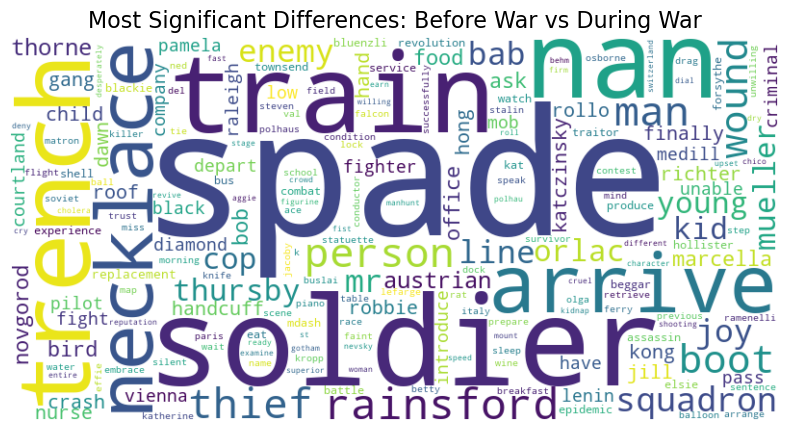

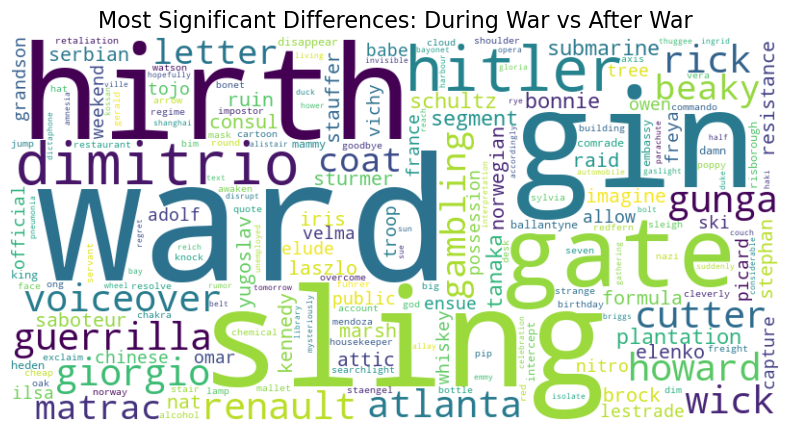

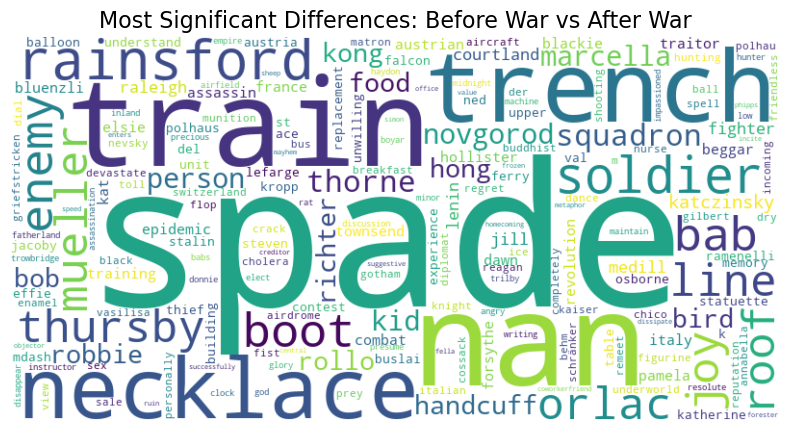

In [34]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re


# Function to preprocess text
def preprocess_text(text, nlp):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and token.is_alpha  # Remove stopwords, punctuation, numbers
    ]
    return tokens

# Function to calculate word frequency differences
def compute_frequency_difference(words1, words2):
    # Count word frequencies for both datasets
    freq1 = Counter(words1)
    freq2 = Counter(words2)
    
    # Get all unique words from both datasets
    all_words = set(freq1.keys()).union(set(freq2.keys()))
    
    # Compute differences
    freq_diff = {word: freq1[word] - freq2[word] for word in all_words}
    
    return freq_diff

# Function to create a word cloud
def plot_word_cloud(freq_diff, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(freq_diff)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Function to remove character names from the plot
def remove_names_from_plot(plot, character_words):
    # List of important WW2 figures
    ww2_figures = [
        "Winston", "Churchill", "Franklin", "Roosevelt", "Joseph", "Stalin", "Adolf", 
        "Hitler", "Benito", "Mussolini", "Hideki", "Tojo", "Dwight", "Eisenhower",
        "George", "Patton", "Douglas", "MacArthur", "Chester", "Nimitz", "Bernard",
        "Montgomery", "Georgy", "Zhukov", "Harry", "Truman", "Charles", "de Gaulle",
        "Hirohito", "Isoroku", "Yamamoto", "Omar", "Bradley", "Erwin", "Rommel",
        "Heinrich", "Himmler", "Albert", "Speer"
    ]
    
    ww2_figures_lower = [name.lower() for name in ww2_figures]
    
    # Ensure proper formatting and lowercase everything
    plot = ' '.join(plot.split()).lower()

    # For each word in the character names
    for word in character_words:
        word_lower = word.lower()
        if word_lower not in ww2_figures_lower:
            plot = re.sub(rf'\b{re.escape(word_lower)}\b', '', plot)

    words_to_remove = [
        "barton", "courtney", "nora", "ackroyd", "hannay", "lily", 
        "rhett", "neff", "thorndike", "ashley", "melanie", "laura", 
        "kulkov", "torsten", "din", "beaumont", "mildred", "daffy", 
        "johnnie", "keyes", "tara", "petersen", "mcpherson", "edwardes", "dr", 
        "elena", "hammond", "peters", "yvonne"
    ]

    for word in words_to_remove:
        word_lower = word.lower()
        plot = re.sub(rf'\b{re.escape(word_lower)}\b', '', plot)

    return plot


# Function to remove character names from all plots in a dataframe
def remove_names_from_plots(df):
    list_characters_names = df['Character_Name'].tolist()
    character_words = [word for name in list_characters_names for word in name.split()]
    character_words = list(set(character_words))

    # Remove character names from all plots
    df['Plot'] = df.apply(lambda x: remove_names_from_plot(x['Plot'], character_words), axis=1)

    return df


# Function to print top 20 words with largest differences in frequency
def print_top_20_difference(freq_diff):
    # Get the 20 most common words with the largest differences
    top_20_diff = Counter(freq_diff).most_common(20)
    print("\nTop 20 words with the largest frequency differences:")
    for word, diff in top_20_diff:
        print(f"{word}: {diff}")


# Load your datasets (assuming 'villain_analysis' is your dataset)
dataset_with_removed_names = villain_analysis.copy()
dataset_with_removed_names = remove_names_from_plots(dataset_with_removed_names)
dataset_with_removed_names = dataset_with_removed_names.drop_duplicates(subset='Plot')

# Split data into periods
before_war = select_period(dataset_with_removed_names, 1930, 1938)
during_war = select_period(dataset_with_removed_names, 1939, 1945)
after_war = select_period(dataset_with_removed_names, 1946, 1955)

before_copy = before_war.copy()
during_copy = during_war.copy()
after_copy = after_war.copy()

before_copy = before_copy['Plot'].dropna().tolist()
during_copy = during_copy['Plot'].dropna().tolist()
after_copy = after_copy['Plot'].dropna().tolist()

# Preprocess text for each dataset
before_war_words = []
during_war_words = []
after_war_words = []

# Tokenize and process text
nlp = spacy.load("en_core_web_sm")

for plot in before_copy:
    before_war_words.extend(preprocess_text(plot, nlp))

for plot in during_copy:
    during_war_words.extend(preprocess_text(plot, nlp))

for plot in after_copy:
    after_war_words.extend(preprocess_text(plot, nlp))

# Compute frequency differences
before_vs_during_diff = compute_frequency_difference(before_war_words, during_war_words)
during_vs_after_diff = compute_frequency_difference(during_war_words, after_war_words)
before_vs_after_diff = compute_frequency_difference(before_war_words, after_war_words)

# Print the top 20 words with the largest frequency differences
print("\nBefore War vs During War")
print_top_20_difference(before_vs_during_diff)

print("\nDuring War vs After War")
print_top_20_difference(during_vs_after_diff)

print("\nBefore War vs After War")
print_top_20_difference(before_vs_after_diff)

# Plot word clouds
plot_word_cloud(before_vs_during_diff, "Most Significant Differences: Before War vs During War")
plot_word_cloud(during_vs_after_diff, "Most Significant Differences: During War vs After War")
plot_word_cloud(before_vs_after_diff, "Most Significant Differences: Before War vs After War")


Get associated words function :

In [ ]:
def get_associated_words(character_name, plot):

    associated_words = []
    characters_name_parts = character_name.lower().split()

    nlp = spacy.load("en_core_web_sm") # load the spacy model in english
    nlp_coref = spacy.load("en_coreference_web_trf") # load the spacy model with coreference resolution
    nlp_coref.replace_listeners("transformer", "coref", ["model.tok2vec"])
    nlp_coref.replace_listeners("transformer", "span_resolver", ["model.tok2vec"])
    nlp.add_pipe("coref", source=nlp_coref)
    nlp.add_pipe("span_resolver", source=nlp_coref)

    doc = nlp(plot) # Tokenization
    coref_dict = doc.spans

    nb_clusters = int(len(coref_dict)/2)
    corref_clusters = []

    for i in range(nb_clusters):
        corref_list = coref_dict[f'coref_head_clusters_{i+1}']
        corref_list = [token.text for token in corref_list]
        corref_clusters.append(corref_list)

    for corref_words in corref_clusters:
        corref_words = [word.lower() for word in corref_words]
        if any(name_part in corref_words for name_part in characters_name_parts):
            corref_list = corref_words
            break

    corref_list = [word for word in corref_list if word not in nlp.Defaults.stop_words]
    characters_name_parts.extend(corref_list)
    characters_name_parts = list(set(characters_name_parts))

    sentences = [sent.text for sent in doc.sents]

    for sentence in sentences:

        sentence_text = sentence.lower()

        if any(name_part in sentence_text for name_part in characters_name_parts): # we want to focus on the sentences where the character appears
        
            for token in nlp(sentence_text):

                token_word = token.text
                token_head = token.head.text
                token_children = [child.text for child in token.children]

                # if token_word is refering the character, we want to keep the head and the children
                if token_word.lower() in characters_name_parts:
                    associated_words.append(token_head)
                    associated_words.extend(token_children)

                # if token_word is an adjective, we want to keep it if the head is refering the character
                if token.pos_ == 'ADJ' and token_head.lower() in characters_name_parts:
                    associated_words.append(token_word)

                # if one of the children is reffering the character, we want to keep the other children
                for child in token_children:
                    if child.lower() in characters_name_parts:
                        associated_words.extend(token_children)


    associated_words = [word.lower() for word in associated_words]
    associated_words.extend(characters_name_parts)

    # We want to remove from the list : character name, stopwords, punctuation, and duplicates
    associated_words = list(set(associated_words))
    associated_words = [word for word in associated_words if word.lower() != character_name.lower()]
    associated_words = [word for word in associated_words if word not in nlp.Defaults.stop_words]
    associated_words = [word for word in associated_words if word.isalpha()]

    return associated_words

# SEPARAAAAAAAAAAATION

# DRAFTTTT

In [33]:
# check for a word in the plots

def check_word_in_plot(row, word):
    if pd.isna(row['Plot']):
        return False
    return word.lower() in row['Plot'].lower()

# check for the word "villain" in the plots

dataset_with_removed_names['Villain_in_plot'] = dataset_with_removed_names.apply(lambda x: check_word_in_plot(x, 'keye'), axis=1)

print("Number of movies with the word 'villain' in the plot: ", dataset_with_removed_names['Villain_in_plot'].sum())
# print the plot of the movie with the word "villain" in the plot

print(dataset_with_removed_names[dataset_with_removed_names['Villain_in_plot'] == True]['Plot'].values[0])

Number of movies with the word 'villain' in the plot:  1
  ,  successful insurance salesman for pacific all risk, returns to his office building in downtown los angeles late one night. he is clearly in pain as he sits down  his desk  begins dictating  memo into  dictaphone machine for colleague  keyes ,  claims adjuster.  dictation becomes  story   film, which is told in flashback:  first meets  alluring   during  routine  call to renew an automobile insurance policy for her husband.  flirtation develops,  least until  asks how she could take out  policy  her husband's life without his knowing it.  realizes she is contemplating murder,  he wants no part  it.  pursues  to his own home, though,  ups  ante — or  least  voltage —  her flirtation; 's gullibility  libido quickly overcome his caution,  he agrees that  two  them, together, will kill her husband.  knows all  tricks  his trade,  course,  comes up with  plan in which 's husband will die an unlikely death, in this case falling fro

In [ ]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text
def preprocess_text(text):
    # Tokenize and process text
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and token.is_alpha  # Remove stopwords, punctuation, numbers
    ]
    return tokens

# Function to calculate word frequency differences
def compute_frequency_difference(words1, words2):
    # Count word frequencies for both datasets
    freq1 = Counter(words1)
    freq2 = Counter(words2)
    
    # Get all unique words from both datasets
    all_words = set(freq1.keys()).union(set(freq2.keys()))
    
    # Compute differences
    freq_diff = {word: freq1[word] - freq2[word] for word in all_words}
    
    return freq_diff

# Function to create a word cloud
def plot_word_cloud(freq_diff, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(freq_diff)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Load your datasets
before_war = before_war['Plot'].dropna().tolist()
during_war = during_war['Plot'].dropna().tolist()
after_war = after_war['Plot'].dropna().tolist()

# Preprocess text for each dataset
before_war_words = []
during_war_words = []
after_war_words = []

for plot in before_war:
    before_war_words.extend(preprocess_text(plot))

for plot in during_war:
    during_war_words.extend(preprocess_text(plot))

for plot in after_war:
    after_war_words.extend(preprocess_text(plot))

# Compute frequency differences
before_vs_during_diff = compute_frequency_difference(before_war_words, during_war_words)
during_vs_after_diff = compute_frequency_difference(during_war_words, after_war_words)
before_vs_after_diff = compute_frequency_difference(before_war_words, after_war_words)

# Plot word clouds
plot_word_cloud(before_vs_during_diff, "Most Significant Differences: Before War vs During War")
plot_word_cloud(during_vs_after_diff, "Most Significant Differences: During War vs After War")
plot_word_cloud(before_vs_after_diff, "Most Significant Differences: Before War vs After War")


In [ ]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# List of important WW2 figures
ww2_figures = [
    "Winston", "Churchill", "Franklin", "Roosevelt", "Joseph", "Stalin", "Adolf", 
    "Hitler", "Benito", "Mussolini", "Hideki", "Tojo", "Dwight", "Eisenhower",
    "George", "Patton", "Douglas", "MacArthur", "Chester", "Nimitz", "Bernard",
    "Montgomery", "Georgy", "Zhukov", "Harry", "Truman", "Charles", "de Gaulle",
    "Hirohito", "Isoroku", "Yamamoto", "Omar", "Bradley", "Erwin", "Rommel",
    "Heinrich", "Himmler", "Albert", "Speer"
]

# Convert to lowercase for case-insensitive comparison
ww2_figures_lower = [name.lower() for name in ww2_figures]

# Function to preprocess text
def preprocess_text(text):
    # Tokenize and process text
    doc = nlp(text.lower())
    tokens = []
    
    for token in doc:
        # Check if the token is a person and not in WW2 figures (remove generic names)
        if token.ent_type_ == "PERSON" and token.text.lower() not in ww2_figures_lower:
            continue  # Skip generic names
        
        # Include tokens that are not stopwords, punctuation, or numbers
        if not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_)
    
    return tokens

# Function to calculate word frequency differences
def compute_frequency_difference(words1, words2):
    # Count word frequencies for both datasets
    freq1 = Counter(words1)
    freq2 = Counter(words2)
    
    # Get all unique words from both datasets
    all_words = set(freq1.keys()).union(set(freq2.keys()))
    
    # Compute differences
    freq_diff = {word: freq1[word] - freq2[word] for word in all_words}
    
    return freq_diff

# Function to create a word cloud
def plot_word_cloud(freq_diff, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(freq_diff)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Load your datasets
before_war = before_war['Plot'].dropna().tolist()
during_war = during_war['Plot'].dropna().tolist()
after_war = after_war['Plot'].dropna().tolist()

# Preprocess text for each dataset
before_war_words = []
during_war_words = []
after_war_words = []

for plot in before_war:
    before_war_words.extend(preprocess_text(plot))

for plot in during_war:
    during_war_words.extend(preprocess_text(plot))

for plot in after_war:
    after_war_words.extend(preprocess_text(plot))

# Compute frequency differences
before_vs_during_diff = compute_frequency_difference(before_war_words, during_war_words)
during_vs_after_diff = compute_frequency_difference(during_war_words, after_war_words)
before_vs_after_diff = compute_frequency_difference(before_war_words, after_war_words)

# Plot word clouds
plot_word_cloud(before_vs_during_diff, "Most Significant Differences: Before War vs During War")
plot_word_cloud(during_vs_after_diff, "Most Significant Differences: During War vs After War")
plot_word_cloud(before_vs_after_diff, "Most Significant Differences: Before War vs After War")


In [179]:
def remove_names_from_plots(row):

    # List of important WW2 figures
    ww2_figures = [
        "Winston", "Churchill", "Franklin", "Roosevelt", "Joseph", "Stalin", "Adolf", 
        "Hitler", "Benito", "Mussolini", "Hideki", "Tojo", "Dwight", "Eisenhower",
        "George", "Patton", "Douglas", "MacArthur", "Chester", "Nimitz", "Bernard",
        "Montgomery", "Georgy", "Zhukov", "Harry", "Truman", "Charles", "de Gaulle",
        "Hirohito", "Isoroku", "Yamamoto", "Omar", "Bradley", "Erwin", "Rommel",
        "Heinrich", "Himmler", "Albert", "Speer"
    ]

    ww2_figures_lower = [name.lower() for name in ww2_figures]

    character_words = row['Character_Name'].split()
    plot = row['Plot']
    # make sure to remove unnecessary spaces from the text, and lowercase everything
    plot = ' '.join(plot.split()).lower()

    for word in character_words:
        if word.lower() in plot.lower() and word.lower() not in ww2_figures_lower:
            plot = plot.replace(word, '')

    return plot

dataset_with_removed_names = villain_analysis.copy()
dataset_with_removed_names['Plot'] = dataset_with_removed_names.apply(remove_names_from_plots, axis=1)

In [ ]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
     

# Function to preprocess text
def preprocess_text(text):

    # Load spaCy model
    nlp = spacy.load("en_core_web_sm")

    # Tokenize and process text
    doc = nlp(text.lower())
    tokens = []
    
    for token in doc:     
        # Include tokens that are not stopwords, punctuation, or numbers
        if not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_)
    
    return tokens

# Function to calculate word frequency differences
def compute_frequency_difference(words1, words2):
    # Count word frequencies for both datasets
    freq1 = Counter(words1)
    freq2 = Counter(words2)
    
    # Get all unique words from both datasets
    all_words = set(freq1.keys()).union(set(freq2.keys()))
    
    # Compute differences
    freq_diff = {word: freq1[word] - freq2[word] for word in all_words}
    
    return freq_diff

# Function to create a word cloud
def plot_word_cloud(freq_diff, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(freq_diff)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


def remove_names_from_plots(row):

    # List of important WW2 figures
    ww2_figures = [
        "Winston", "Churchill", "Franklin", "Roosevelt", "Joseph", "Stalin", "Adolf", 
        "Hitler", "Benito", "Mussolini", "Hideki", "Tojo", "Dwight", "Eisenhower",
        "George", "Patton", "Douglas", "MacArthur", "Chester", "Nimitz", "Bernard",
        "Montgomery", "Georgy", "Zhukov", "Harry", "Truman", "Charles", "de Gaulle",
        "Hirohito", "Isoroku", "Yamamoto", "Omar", "Bradley", "Erwin", "Rommel",
        "Heinrich", "Himmler", "Albert", "Speer"
    ]

    ww2_figures_lower = [name.lower() for name in ww2_figures]

    character_words = row['Character_Name'].split()
    plot = row['Plot']
    # make sure to remove unnecessary spaces from the text, and lowercase everything
    plot = ' '.join(plot.split()).lower()

    for word in character_words:
        if word.lower() in plot.lower() and word.lower() not in ww2_figures_lower:
            plot = plot.replace(word, '')

    return plot

dataset_with_removed_names = villain_analysis.copy()
dataset_with_removed_names['Plot'] = dataset_with_removed_names.apply(remove_names_from_plots, axis=1)

In [ ]:
# Load your datasets
before_war = select_period(dataset_with_removed_names, 1930, 1938)
during_war = select_period(dataset_with_removed_names, 1939, 1945)
after_war = select_period(dataset_with_removed_names, 1946, 1955)

before_war = before_war['Plot'].dropna().tolist()
during_war = during_war['Plot'].dropna().tolist()
after_war = after_war['Plot'].dropna().tolist()

# Preprocess text for each dataset
before_war_words = []
during_war_words = []
after_war_words = []

for plot in before_war:
    before_war_words.extend(preprocess_text(plot))

for plot in during_war:
    during_war_words.extend(preprocess_text(plot))

for plot in after_war:
    after_war_words.extend(preprocess_text(plot))

# Compute frequency differences
before_vs_during_diff = compute_frequency_difference(before_war_words, during_war_words)
during_vs_after_diff = compute_frequency_difference(during_war_words, after_war_words)
before_vs_after_diff = compute_frequency_difference(before_war_words, after_war_words)

# Plot word clouds
plot_word_cloud(before_vs_during_diff, "Most Significant Differences: Before War vs During War")
plot_word_cloud(during_vs_after_diff, "Most Significant Differences: During War vs After War")
plot_word_cloud(before_vs_after_diff, "Most Significant Differences: Before War vs After War")


In [152]:


villain_names = get_character_names(villain_analysis)

In [ ]:
villain_names

In [ ]:
# check wether the name "gutman" is in the list of villain names

def check_name_in_list(name, names_list):
    for names in names_list:
        if name in names:
            return True
    return False

check_name_in_list("scarlett", villain_names)

In [ ]:
# check wether the word "Pineapple" appear in one of the plots of the villain_analysis dataset, also return number of occurences

before_war = select_period(villain_analysis, 1930, 1938)
during_war = select_period(villain_analysis, 1939, 1945)
after_war = select_period(villain_analysis, 1946, 1955)

def check_word_in_plot(word, df):
    count = 0
    for plot in df['Plot']:
        if word.lower() in plot.lower():
            count += 1
    return count

def check_word_in_charcter_name(word, df):
    count = 0
    for character in df['Character_Name']:
        if word.lower() in character.lower():
            count += 1
    return count

In [ ]:
check_word_in_plot("scarlett", dataset_with_removed_names)

In [ ]:
check_word_in_charcter_name("ashley", after_war)

In [ ]:
# Find the row were the word 'Scarlett' appears in the character name

def find_word_in_character_name(word, df):
    return df[df['Character_Name'].apply(lambda x: word.lower() in x.lower())]

# print the plot were the name 'Scarlett' appears in the character name

scarlett = find_word_in_character_name("gutman", before_war)
print(scarlett['Movie_name'].values)

def find_word_in_plot(word, df):
    return df[df['Plot'].apply(lambda x: word.lower() in x.lower())]

# print the character name were the word 'Scarlett' appears in the plot

scarlett = find_word_in_plot("gutman", before_war)
print(scarlett['Movie_name'].values)





In [ ]:
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter



# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load your dataset
# Replace 'your_dataset.csv' and 'plot_column' with your actual dataset and column name
df = villain_analysis
plots = df['Plot'].dropna().tolist()

# Function to preprocess text
def preprocess_text(text):
    # Tokenize and process the text with spaCy
    doc = nlp(text.lower())  # Convert to lowercase
    tokens = [
        token.lemma_  # Lemmatization
        for token in doc
        if not token.is_stop and token.is_alpha  # Remove stopwords and keep only alphabetic tokens
    ]
    return tokens

# Combine all plots and preprocess
all_words = []
for plot in plots:
    all_words.extend(preprocess_text(plot))

# Count word frequencies
word_freq = Counter(all_words)

# Create a word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
).generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Movie Plots")
plt.show()


In [42]:
def get_associated_words(character_name, plot):

    associated_words = []
    characters_name_parts = character_name.lower().split()

    nlp = spacy.load("en_core_web_sm") # load the spacy model in english
    nlp_coref = spacy.load("en_coreference_web_trf") # load the spacy model with coreference resolution
    nlp_coref.replace_listeners("transformer", "coref", ["model.tok2vec"])
    nlp_coref.replace_listeners("transformer", "span_resolver", ["model.tok2vec"])
    nlp.add_pipe("coref", source=nlp_coref)
    nlp.add_pipe("span_resolver", source=nlp_coref)

    doc = nlp(plot) # Tokenization
    coref_dict = doc.spans

    nb_clusters = int(len(coref_dict)/2)
    corref_clusters = []

    for i in range(nb_clusters):
        corref_list = coref_dict[f'coref_head_clusters_{i+1}']
        corref_list = [token.text for token in corref_list]
        corref_clusters.append(corref_list)

    for corref_words in corref_clusters:
        corref_words = [word.lower() for word in corref_words]
        if any(name_part in corref_words for name_part in characters_name_parts):
            corref_list = corref_words
            break

    corref_list = [word for word in corref_list if word not in nlp.Defaults.stop_words]
    characters_name_parts.extend(corref_list)
    characters_name_parts = list(set(characters_name_parts))
    characters_name_parts = [word for word in characters_name_parts if word not in nlp.Defaults.stop_words]

    sentences = [sent.text for sent in doc.sents]

    for sentence in sentences:

        sentence_text = sentence.lower()

        if any(name_part in sentence_text for name_part in characters_name_parts): # we want to focus on the sentences where the character appears
        
            for token in nlp(sentence_text):

                token_word = token.text
                token_head = token.head.text
                token_children = [child.text for child in token.children]

                # if token_word is refering the character, we want to keep the head and the children
                if token_word.lower() in characters_name_parts:
                    associated_words.append(token_head)
                    associated_words.extend(token_children)

                # if token_word is an adjective, we want to keep it
                if token.pos_ == 'ADJ':
                    associated_words.append(token_word)

                # if one of the children is reffering the character, we want to keep the other children
                for child in token_children:
                    if child.lower() in characters_name_parts:
                        associated_words.extend(token_children)

                # if token head is reffering the character, we want to keep the children
                if token_head.lower() in characters_name_parts:
                    associated_words.extend(token_children)


    associated_words = [word.lower() for word in associated_words]
    associated_words.extend(characters_name_parts)

    # We want to remove from the list : character name, stopwords, punctuation, and duplicates
    associated_words = list(set(associated_words))
    associated_words = [word for word in associated_words if word.lower() != character_name.lower()]
    associated_words = [word for word in associated_words if word not in nlp.Defaults.stop_words]
    associated_words = [word for word in associated_words if word.isalpha()]

    return associated_words

In [ ]:
random_row = villain_analysis.sample()
character_name = random_row['Character_Name'].values[0]
plot = random_row['Plot'].values[0]

# character_name = "Prince William"
# plot = "William, prince of England, has beautiful eyes and likes to play volleyball. He is the son of Charles and Diana."

print("Character name: ", character_name)
print("Plot: ", plot)


associated_words = get_associated_words(character_name, plot)

In [ ]:
associated_words